In [741]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats

df_t1 = pd.read_csv('/content/t1_user_active_min.csv')
df_t2 = pd.read_csv('/content/t2_user_variant.csv')
df_t3 = pd.read_csv('/content/t3_user_active_min_pre.csv')
df_t4 = pd.read_csv('/content/t4_user_attributes.csv')

# merge datasets such that variant number is associated with each uid
df_t2_selected = df_t2[['uid', 'variant_number']]
df_merged = df_t1.join(df_t2_selected.set_index('uid'), on='uid', how='right', lsuffix='_caller', rsuffix='_other')
df_merged.head()

# split the dataset into control and treatment groups
df_treatment = df_merged.loc[df_merged['variant_number'] == 1]
df_control = df_merged.loc[df_merged['variant_number'] == 0]

# sum the minutes for each user and remove other fields
df_treatment = df_treatment.groupby(['uid'])['active_mins'].sum()
df_control = df_control.groupby(['uid'])['active_mins'].sum()

# export the new csv files
#df_treatment.to_csv('treatment_group_active_min_sum.csv', index=True)
#df_control.to_csv('control_group_active_min_sum.csv', index=True)

# run independent t-test on the two groups
treatment = df_treatment[df_treatment > 0]
control = df_control[df_control > 0]
ttest_ind(treatment, control)

# the resulting pvalue of 0.7 is very high, which suggests no strong evidence of a difference
# I find this value suspicious


TtestResult(statistic=-0.32346507126292273, pvalue=0.7463445065262613, df=46631.0)

In [742]:
# find the mean and median for each group
print(treatment.mean())
print(treatment.median())
print(control.mean())
print(control.median())

# the means and medians are wildly skewed

784.2028670721112
71.0
837.6428857715431
52.0


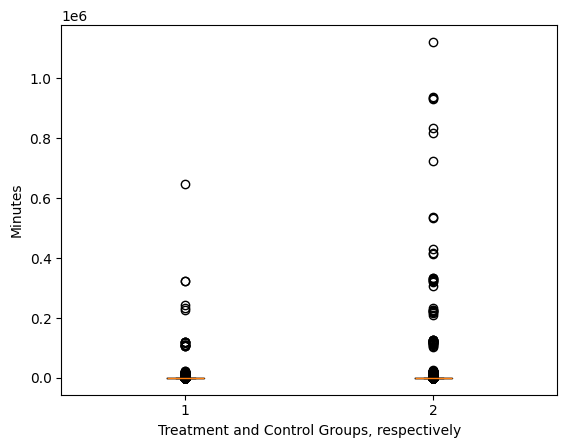

In [743]:
plt.boxplot([treatment, control])
plt.ylabel('Minutes')
plt.xlabel('Treatment and Control Groups, respectively')
plt.show()

In [744]:
# this dataframe has an impossible value
df_t1.max()

,0
uid,49999
dt,2019-07-05
active_mins,99999.0


In [745]:
# calculate Interquartile Range (IQR) for active_mins values in each set
Q1 = df_treatment.quantile(0.25)
Q3 = df_treatment.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_treatment = df_treatment[(df_treatment < Q1 - IQR) | (df_treatment > Q3 + IQR)]

print(outliers_treatment)

uid
40009     553.0
40013     517.0
40016    3171.0
40020     538.0
40022     486.0
          ...  
49979     618.0
49982    3370.0
49984     841.0
49985     531.0
49998     597.0
Name: active_mins, Length: 1589, dtype: float64


In [746]:
# calculate IQR for active_mins
Q1 = df_control.quantile(0.25)
Q3 = df_control.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control = df_control[(df_control < Q1 - IQR) | (df_control > Q3 + IQR)]

print(outliers_control)

uid
1        15205.0
17        5462.0
19         551.0
25         359.0
29        3787.0
          ...   
39971      355.0
39973     4023.0
39978     1343.0
39986      558.0
39994      378.0
Name: active_mins, Length: 6749, dtype: float64


In [747]:
# exclude the outliers from both sets
df_treatment_filtered = df_treatment.drop(outliers_treatment.index)
df_control_filtered = df_control.drop(outliers_control.index)

# print maxes before and after
print(df_treatment.max())
print(df_control.max())

print(df_treatment_filtered.max())
print(df_control_filtered.max())
print(df_treatment_filtered.count())
print(df_control_filtered.count())

646736.0
1121783.0
384.0
328.0
8411
33251


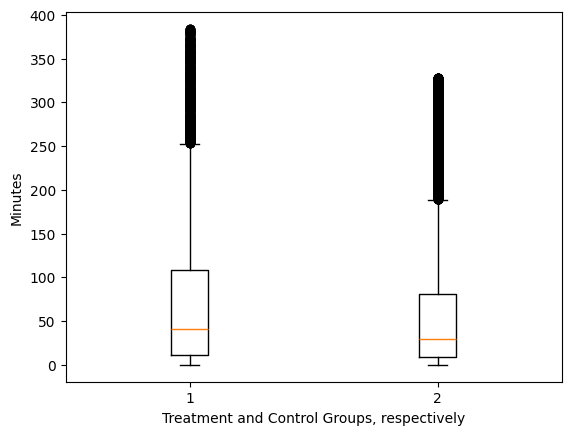

In [748]:
# create another boxplot to see the new sets
plt.boxplot([df_treatment_filtered, df_control_filtered])
plt.ylabel('Minutes')
plt.xlabel('Treatment and Control Groups, respectively')
plt.show()

In [749]:
# now that I can see the outlier max values, remove outliers manually
outliers_control = df_control_filtered[df_control_filtered >= 100]
df_control_filtered = df_control_filtered.drop(outliers_control.index)
outliers_treatment = df_treatment_filtered[(df_treatment_filtered >= 160)]
df_treatment_filtered = df_treatment_filtered.drop(outliers_treatment.index)

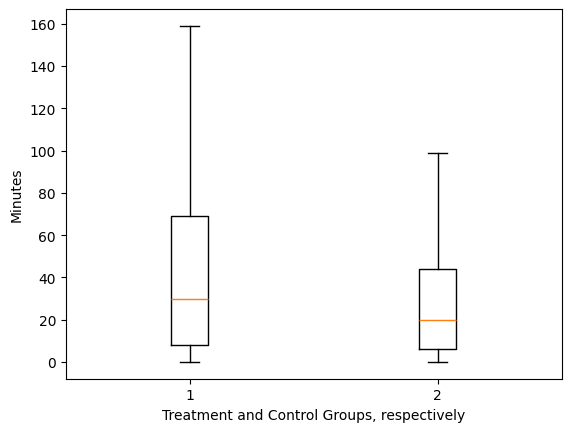

In [750]:
# create another boxplot to see the new sets
plt.boxplot([df_treatment_filtered, df_control_filtered])
# label plots
plt.ylabel('Minutes')
plt.xlabel('Treatment and Control Groups, respectively')
plt.show()

In [751]:
# run independent t-test on the two groups again now that outliers are filtered
treatment = df_treatment_filtered[df_treatment_filtered > 0]
control = df_control_filtered[df_control_filtered > 0]
ttest_ind(treatment, control)


TtestResult(statistic=41.75965577212747, pvalue=0.0, df=30265.0)

In [752]:
# find the mean and median for each filtered group
print(df_treatment_filtered.mean())
print(df_treatment_filtered.median())
print(df_control_filtered.mean())
print(df_control_filtered.median())


43.5044994375703
30.0
28.201643918256543
20.0


In [753]:
# test the normality of each set
print(stats.shapiro(df_treatment_filtered))
print(stats.shapiro(df_control_filtered))

ShapiroResult(statistic=0.8758864369089674, pvalue=1.0426198327594599e-59)
ShapiroResult(statistic=0.8847444331415818, pvalue=3.3708985625458386e-86)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7112.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26522.
  res = hypotest_fun_out(*samples, **kwds)


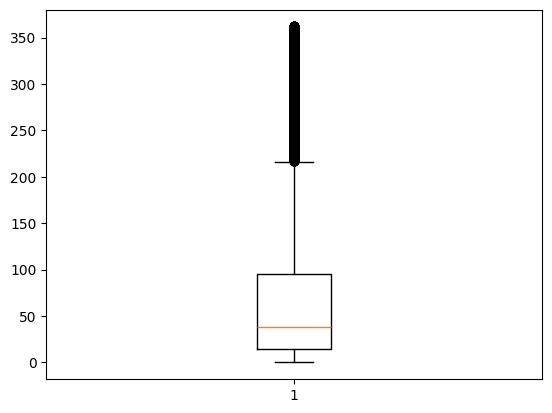

In [754]:
# analyze df_t3
# merge datasets such that variant number is associated with each uid
df_t2_selected = df_t2[['uid', 'variant_number']]
df_merged = df_t3.join(df_t2_selected.set_index('uid'), on='uid', how='right', lsuffix='_caller', rsuffix='_other')

# remove the treatment group
df_control_pre_update = df_merged.loc[df_merged['variant_number'] == 0]

# sum the minutes for each user and remove other fields
df_control_pre_update = df_control_pre_update.groupby(['uid'])['active_mins'].sum()
df_control_pre_update.head()

# remove outliers
# calculate IQR for active_mins
Q1 = df_control_pre_update.quantile(0.25)
Q3 = df_control_pre_update.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control_pre_update = df_control_pre_update[(df_control_pre_update < Q1 - IQR) | (df_control_pre_update > Q3 + IQR)]
df_control_pre_update = df_control_pre_update.drop(outliers_control_pre_update.index)

# boxplot new group
plt.boxplot([df_control_pre_update])
plt.show()

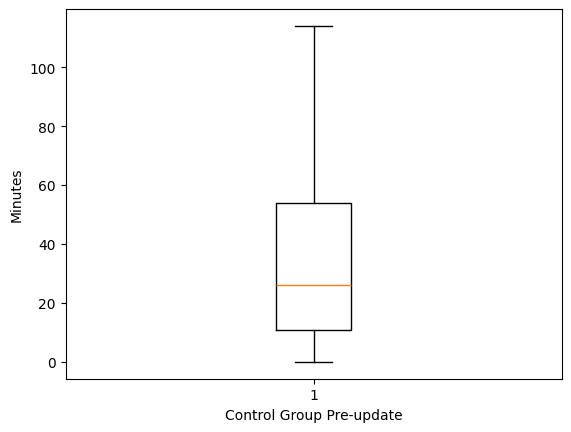

In [755]:
# remove outliers manually
outliers_control_pre_update = df_control_pre_update[df_control_pre_update >= 115]
df_control_pre_update = df_control_pre_update.drop(outliers_control_pre_update.index)

# plot again
plt.boxplot([df_control_pre_update])
# label
plt.ylabel('Minutes')
plt.xlabel('Control Group Pre-update')
plt.show()

In [756]:
# look for any statistically significant difference between control group pre and post update using t-test
control_pre_update = df_control_pre_update[df_control_pre_update > 0]
control_post_update = df_control_filtered[df_control_filtered > 0]
ttest_ind(control_pre_update, control_post_update)

TtestResult(statistic=16.702107010397665, pvalue=1.8660238875990016e-62, df=50236.0)

In [757]:
# mean and median for new group
print(df_control_pre_update.mean())
print(df_control_pre_update.median())

35.1200829719027
26.0


In [758]:
# test the normality of the pre_update set
print(stats.shapiro(df_control_pre_update))

ShapiroResult(statistic=0.8951517367103534, pvalue=5.456329239401593e-84)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26515.
  res = hypotest_fun_out(*samples, **kwds)


In [759]:
# analyze df_t4
# pre update
df_t2_selected = df_t2[['uid', 'variant_number']]
df_merged_pre_update = df_t3.join(df_t4.set_index('uid'), on='uid', how='right', lsuffix='_caller', rsuffix='_other')
df_merged_pre_update = df_merged_pre_update.join(df_t2_selected.set_index('uid'), on='uid', how='left')

# split the dataset into control and treatment groups
df_treatment_pre_update = df_merged_pre_update.loc[df_merged_pre_update['variant_number'] == 1]
df_control_pre_update = df_merged_pre_update.loc[df_merged_pre_update['variant_number'] == 0]

In [760]:
# post update
df_t2_selected = df_t2[['uid', 'variant_number']]
df_merged_post_update = df_t1.join(df_t4.set_index('uid'), on='uid', how='right', lsuffix='_caller', rsuffix='_other')
df_merged_post_update = df_merged_post_update.join(df_t2_selected.set_index('uid'), on='uid', how='left')


# Now you can split the dataset into control and treatment groups
df_treatment_post_update = df_merged_post_update.loc[df_merged_post_update['variant_number'] == 1]
df_control_post_update = df_merged_post_update.loc[df_merged_post_update['variant_number'] == 0]

print(df_treatment_post_update.head())
print(df_control_post_update.head())

            uid          dt  active_mins gender   user_type  variant_number
886957.0  40000  2019-02-13          3.0   male    new_user               1
886958.0  40000  2019-03-02         18.0   male    new_user               1
886959.0  40000  2019-03-12          4.0   male    new_user               1
886960.0  40001  2019-02-14         16.0   male  non_reader               1
886961.0  40001  2019-02-17          5.0   male  non_reader               1
     uid          dt  active_mins gender   user_type  variant_number
0.0    0  2019-02-22          5.0   male  non_reader               0
1.0    0  2019-03-11          5.0   male  non_reader               0
2.0    0  2019-03-18          3.0   male  non_reader               0
3.0    0  2019-03-22          4.0   male  non_reader               0
4.0    0  2019-04-03          9.0   male  non_reader               0


In [736]:
# sum both pre and post sets on active_min
df_control_pre_update = df_control_pre_update.groupby(['uid', 'gender', 'user_type'])['active_mins'].sum()
df_control_post_update = df_control_post_update.groupby(['uid', 'gender', 'user_type'])['active_mins'].sum()
df_treatment_pre_update = df_treatment_pre_update.groupby(['uid', 'gender', 'user_type'])['active_mins'].sum()
df_treatment_post_update = df_treatment_post_update.groupby(['uid', 'gender', 'user_type'])['active_mins'].sum()

print(df_control_pre_update.head())
print(df_control_post_update.head())
print(df_treatment_pre_update.head())
print(df_treatment_post_update.head())

uid  gender  user_type 
0    male    non_reader       70.0
1    male    reader        19158.0
2    male    non_reader       37.0
3    male    non_reader      108.0
4    male    non_reader       66.0
Name: active_mins, dtype: float64
uid  gender  user_type 
0    male    non_reader       43.0
1    male    reader        15205.0
2    male    non_reader       17.0
3    male    non_reader       77.0
4    male    non_reader       39.0
Name: active_mins, dtype: float64
uid    gender  user_type 
40000  male    new_user        0.0
40001  male    non_reader    125.0
40002  male    non_reader     90.0
40003  male    non_reader     18.0
40004  female  non_reader     10.0
Name: active_mins, dtype: float64
uid    gender  user_type 
40000  male    new_user       25.0
40001  male    non_reader    299.0
40002  male    non_reader    183.0
40003  male    non_reader      0.0
40004  female  non_reader     56.0
Name: active_mins, dtype: float64


In [737]:
# filter outliers on pre and post sets using IQR
# calculate IQR for active_mins
Q1 = df_control_pre_update.quantile(0.25)
Q3 = df_control_pre_update.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control = df_control_pre_update[(df_control_pre_update < Q1 - IQR) | (df_control_pre_update > Q3 + IQR)]
df_control_pre_update = df_control_pre_update.drop(outliers_control.index)
print(df_control_pre_update.head())

# filter outliers on pre and post sets using IQR
# calculate IQR for active_mins
Q1 = df_control_pre_update.quantile(0.25)
Q3 = df_control_pre_update.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control = df_control_post_update[(df_control_post_update < Q1 - IQR) | (df_control_post_update > Q3 + IQR)]
df_control_post_update = df_control_post_update.drop(outliers_control.index)
print(df_control_pre_update.head())

# filter outliers on pre and post sets using IQR
# calculate IQR for active_mins
Q1 = df_control_pre_update.quantile(0.25)
Q3 = df_control_pre_update.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control = df_treatment_pre_update[(df_treatment_pre_update < Q1 - IQR) | (df_treatment_pre_update > Q3 + IQR)]
df_treatment_pre_update = df_treatment_pre_update.drop(outliers_control.index)
print(df_treatment_pre_update.head())

# filter outliers on pre and post sets using IQR
# calculate IQR for active_mins
Q1 = df_control_pre_update.quantile(0.25)
Q3 = df_control_pre_update.quantile(0.75)
IQR = Q3 - Q1

# identify outliers
outliers_control = df_treatment_post_update[(df_treatment_post_update < Q1 - IQR) | (df_treatment_post_update > Q3 + IQR)]
df_treatment_post_update = df_treatment_post_update.drop(outliers_control.index)
print(df_treatment_post_update.head())

uid  gender  user_type 
0    male    non_reader     70.0
2    male    non_reader     37.0
3    male    non_reader    108.0
4    male    non_reader     66.0
5    female  non_reader     21.0
Name: active_mins, dtype: float64
uid  gender  user_type 
0    male    non_reader     70.0
2    male    non_reader     37.0
3    male    non_reader    108.0
4    male    non_reader     66.0
5    female  non_reader     21.0
Name: active_mins, dtype: float64
uid    gender  user_type 
40000  male    new_user        0.0
40001  male    non_reader    125.0
40002  male    non_reader     90.0
40003  male    non_reader     18.0
40004  female  non_reader     10.0
Name: active_mins, dtype: float64
uid    gender  user_type 
40000  male    new_user      25.0
40003  male    non_reader     0.0
40004  female  non_reader    56.0
40007  female  non_reader    75.0
40010  female  non_reader    21.0
Name: active_mins, dtype: float64


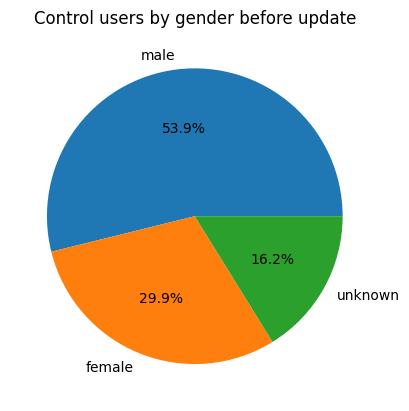

In [738]:
# plot users by gender
gender_counts = df_control_pre_update.reset_index()['gender'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by gender before update')
plt.show()

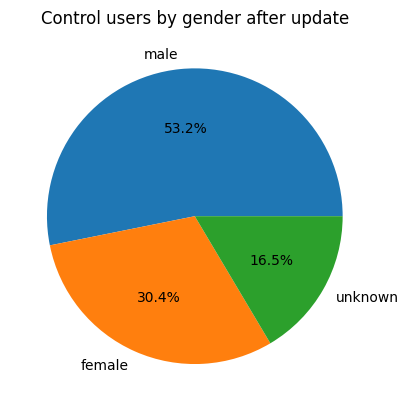

In [739]:
# plot users by gender
gender_counts = df_control_post_update.reset_index()['gender'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by gender after update')
plt.show()

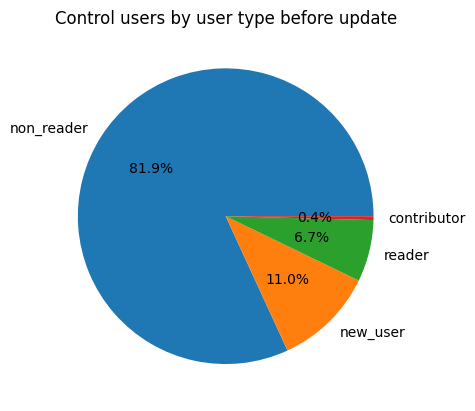

In [740]:
# plot users by user type
gender_counts = df_control_pre_update.reset_index()['user_type'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by user type before update')
plt.show()

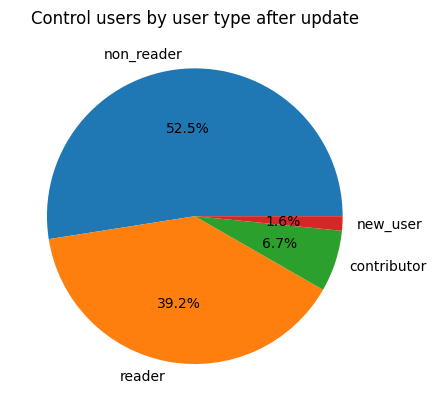

In [761]:
# plot users by user type
gender_counts = df_control_post_update.reset_index()['user_type'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by user type after update')
plt.show()

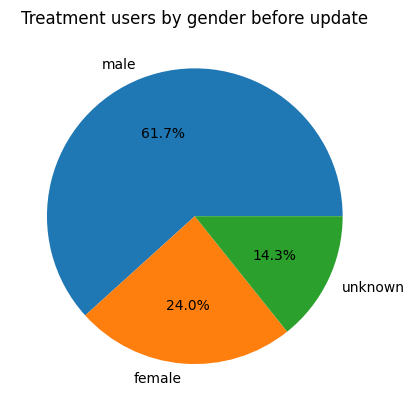

In [763]:
# plot users by gender
gender_counts = df_treatment_pre_update.reset_index()['gender'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Treatment users by gender before update')
plt.show()

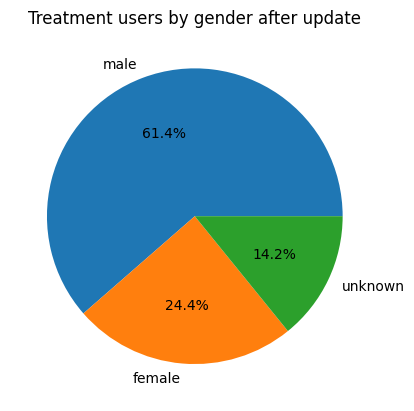

In [764]:
# plot users by gender
gender_counts = df_treatment_post_update.reset_index()['gender'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Treatment users by gender after update')
plt.show()

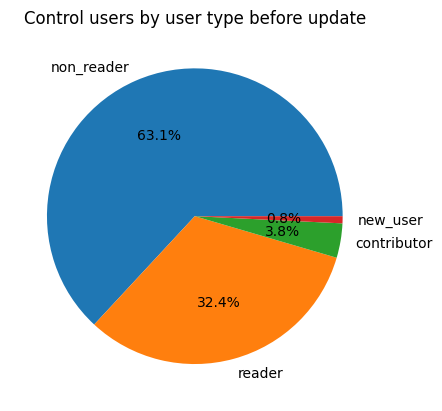

In [765]:
# plot users by user type
gender_counts = df_treatment_pre_update.reset_index()['user_type'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by user type before update')
plt.show()

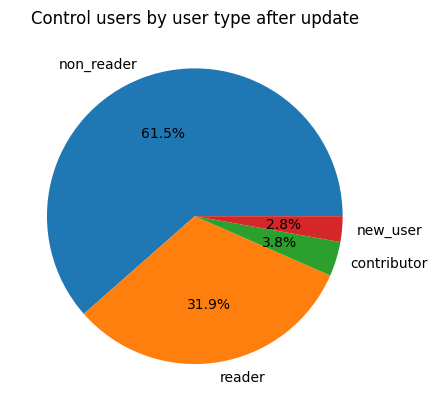

In [767]:
# plot users by user type
gender_counts = df_treatment_post_update.reset_index()['user_type'].value_counts()
# Get unique genders and use them as labels
labels = gender_counts.index.tolist()
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Control users by user type after update')
plt.show()